## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [40]:
import matplotlib.pyplot as plt

import pandas
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-21 13:14:15--  https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932820 (911K) [application/octet-stream]
Saving to: 'public_train_10000.root'

100%[======================================>] 932,820     4.97MB/s   in 0.2s   

2016-06-21 13:14:15 (4.97 MB/s) - 'public_train_10000.root' saved [932820/932820]



In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [4]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-21 13:14:24--  https://2016.mlhep.yandex.net/data/higgs/public_test.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91931408 (88M) [application/octet-stream]
Saving to: 'public_test.root'

100%[======================================>] 91,931,408  3.52MB/s   in 15s    

2016-06-21 13:14:39 (5.92 MB/s) - 'public_test.root' saved [91931408/91931408]



### Read the smallest part of training file and test file

In [41]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

In [12]:
data.tail(5)

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
9995,1009996,0,67.422157,0.047600,-3.007553,200.084793,-2.974597,66.614967,-0.696843,-0.408659,...,-0.741136,0.230067,1.999937,76.811203,161.708084,78.077820,256.428406,72.724876,526.231079,613.824768
9996,1009997,1,51.150311,-1.093824,2.445759,27.797533,2.418964,95.235474,-1.425959,-1.110599,...,0.372612,1.641314,2.000016,53.564301,251.449097,79.853149,166.334030,116.160538,454.949677,603.809753
9997,1009998,1,103.452408,0.567229,-1.793182,8.399943,1.776589,78.138664,0.870871,2.157186,...,0.829123,0.376444,1.999937,82.334373,242.730377,81.179161,192.064148,128.377182,380.536560,551.422424
9998,1009999,0,33.855957,-1.052271,-1.106618,58.648544,2.709328,110.229721,-0.756250,-0.453936,...,-1.734020,-0.177169,0.000000,74.516708,158.312378,85.557083,188.449356,140.375320,264.731140,371.888153
9999,1010000,0,50.133038,1.523453,-0.665432,33.441067,-0.308206,91.515762,1.047847,-3.057928,...,-0.054658,-1.130095,0.000000,130.372681,238.136551,78.980865,175.673080,134.282303,377.124817,487.969818


In [13]:
test.tail(5)

,event_id,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
999995,999996,38.523537,1.613885,2.399679,24.386349,-1.823904,131.737457,1.304169,0.566856,2.000016,...,-1.272945,-1.763102,0,50.397636,173.251953,80.654556,128.019440,45.258812,228.844803,332.475677
999996,999997,84.448395,-0.040267,-2.138890,109.964096,-2.481743,50.259148,0.308118,0.334005,2.000000,...,-1.504321,-0.673184,0,739.199829,759.189941,78.144287,224.591156,162.148849,1118.976562,1198.045410
999997,999998,74.043701,1.878494,-1.932999,14.821092,-2.809260,98.599503,0.788990,1.409131,0.999969,...,0.992709,2.613975,0,85.073784,193.475861,80.187050,224.686096,135.753372,301.967651,412.872284
999998,999999,66.171684,-0.474488,-0.988961,95.307686,0.535798,22.249971,-0.833418,-0.024798,2.000000,...,-0.230724,0.414533,0,401.818756,479.388855,107.272385,240.342514,82.365448,689.026123,928.406311
999999,1000000,37.521900,-0.121569,2.391588,52.437664,-1.680303,20.747028,0.949844,2.268789,0.000000,...,-1.977267,-2.999408,0,34.400902,177.565628,81.583229,113.103706,139.968231,265.002258,361.302765


### Define training features

Exclude `event_id`, `target` from the features set

In [42]:
features = list(set(data.columns) - {'event_id', 'target'})
features

['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Prepare high-level features for training

In [157]:
high_level_features = ['m_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv', ]

### Plot histograms for each high-level feature

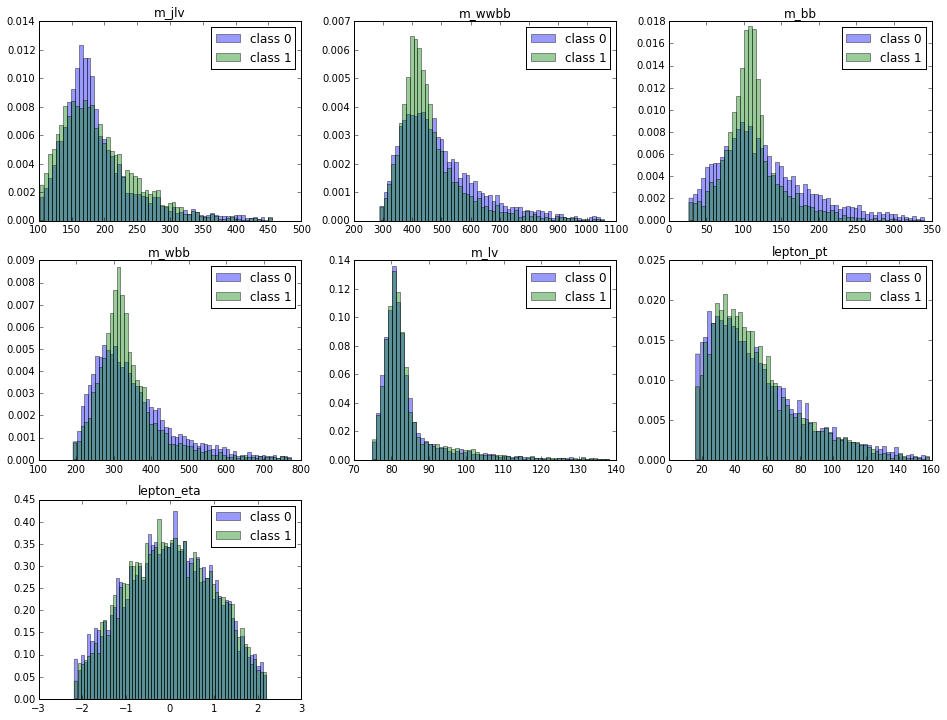

In [158]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [177]:
training_data, validation_data = train_test_split(data, random_state=21, train_size=0.66)

### Simple knn from `sklearn` training

In [160]:
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(training_data[high_level_features], training_data.target)

In [178]:
#BoostDecisionTree
#from sklearn.ensemble import GradientBoostingClassifier
#BDT = GradientBoostingClassifier(init=None, learning_rate=0.10, loss='deviance',
#              max_depth=3, max_features=None, max_leaf_nodes=None,
#              min_samples_leaf=1, min_samples_split=4,
#              min_weight_fraction_leaf=0.01, n_estimators=100,
#              random_state=None, subsample=1.0, verbose=0,
#              warm_start=False)
#BDT.fit(training_data[high_level_features], training_data.target)

#simple DecisionTree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
tree.fit(training_data[high_level_features], training_data.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [180]:
proba = tree.predict_proba(validation_data[high_level_features])

In [181]:
proba

array([[ 0.5       ,  0.5       ],
       [ 0.06666667,  0.93333333],
       [ 0.12727273,  0.87272727],
       ..., 
       [ 0.41428571,  0.58571429],
       [ 0.21296296,  0.78703704],
       [ 0.12      ,  0.88      ]])

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

In [182]:
# take probability to be 1 class to compute ROC AUC
roc_auc_score(validation_data.target, proba[:, 1])

0.64661207869258519

## Prepare submission to kaggle

In [183]:
# predict test sample
kaggle_proba = knn.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

In [18]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/Users/antares/Yandex.Disk.localized/projects/MLHEP/mlhep2016/higgs_kaggle/datasets/baseline.csv